# Rule Based Machine Learning

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.neighbors as neighbors
import sklearn.linear_model as linear
import models
from collections import defaultdict

sns.set(style="whitegrid")

from sklearn.tree import DecisionTreeRegressor as reg
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree

Using the insurance data set, lets construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). We will use validation curves to estimate the best tree depth. We will then perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Lets first import our data set as we did in the previous lab.

In [2]:
ins = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv")
ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We also need to create dummy variables for one hot encoded variables.

In [3]:
ins = pd.concat([ins, pd.get_dummies(ins["sex"])], axis=1)
ins = pd.concat([ins, pd.get_dummies(ins["region"])], axis=1)
ins = pd.concat([ins, pd.get_dummies(ins["smoker"], prefix="smoke")], axis=1)
ins["age_sq"] = ins.age**2
ins["bmi_above_30"] = ins.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

Below are some functions to help produce validation curves. These were taken and modified from the previous lab.

In [4]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def dmatrix_to_array(dmatrix):
    return np.array([row[0] for row in dmatrix])

#cross validation of tree regression
def tree_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            
            # y, X for training data
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            
            #metrics["train"].append(model.score(X, y))
            metrics["train"].append(mse(y, model.predict(X), squared = False))
            
            # y, X for test data
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            #metrics["test"].append(model.score(X,y))
            metrics["test"].append(mse(y, model.predict(X), squared = False))

    
    return metrics

### Validation Curves

Because regression trees are not sensitive to data transformations we can try building our model using all our data as is. We'll also try maximum tree lengths ranging from 1 to 40 and see which ones provide good metrics. We'll use MSE using the mean_squared_error package provided by sklearn.

In [5]:
formula = "charges ~ 0 + bmi + age + male + smoke_yes + children"

Here we generate cross validations using decision trees and tree depths ranging from 1 to 40.

In [6]:
values = range(1,40)

test_curve = []
train_curve = []
for x in values:
    builder = reg(max_depth = x)
    results = tree_cross_validation(formula, builder, ins)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

Here we define a function to plot the validation curves that we generated for the decision trees of varying depths.

In [7]:
def validation_curve(test_data, train_data, xs, metric, parameter, angle = 0):
    figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
    axes = figure.add_subplot(1, 1, 1)

    test_lower, test_mid, test_upper = zip(*test_data)
    train_lower, train_mid, train_upper = zip(*train_data)

    axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
    axes.plot(xs, test_mid, color="firebrick")
    
    axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
    axes.plot(xs, train_mid, color="cornflowerblue")

    axes.set_xticks(xs)
    axes.set_xticklabels([str(x) for x in xs])

    axes.legend()
    axes.set_title("Validation Curves")
    axes.set_xlabel(parameter)
    axes.set_ylabel(metric)
    axes.tick_params(axis='x', labelrotation = angle)
    
    plt.show()
    plt.close()

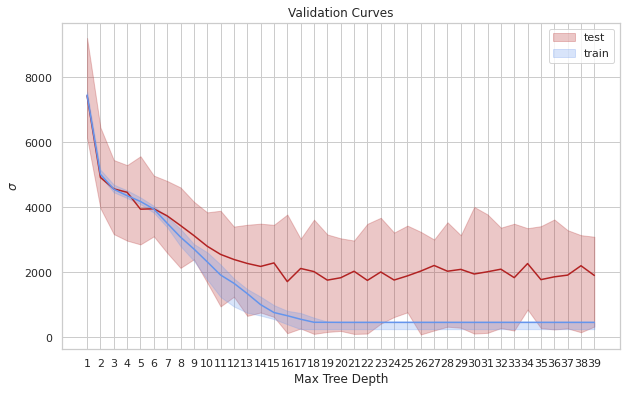

In [8]:
validation_curve(test_curve, train_curve, values, "$\sigma$", "Max Tree Depth")

Setting max tree depth to 15 seems to be a good point given $\sigma$ as our metric. it seems that out test set minimizes at around sigma of 2K. With our parameter selected, we can continue and perform 3 iterations of 10 fold cross-validation to estimate our generalization error.

In [9]:
builder = reg(max_depth = 12)

cval = tree_cross_validation(formula, builder, ins)

The following functions allow us to generate cross validation learning curves.

In [10]:
#Prepares the results dictionary
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

#Calculate learning curves.
def learning_curves(builder, formula, data, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                
                # we calculate the model
                y, X = patsy.dmatrices(formula, train_data_chunk, return_type="matrix")
                model = builder.fit(X, y)
                y_hat = model.predict(X)
                results["train"][i].append(mse(y, y_hat, squared = False))
                
                # y, X for test data
                y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
                y_hat = model.predict(X)
                results["test"][i].append(mse(y, y_hat, squared = False))
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

#Convert results to data useable by a function to plot the learning curves
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

#Function to plot the learning curves.
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

### Learning Curves

Now lets generate the learning curves using the functions we defined.

In [11]:
lcurves = learning_curves(builder, formula, ins)

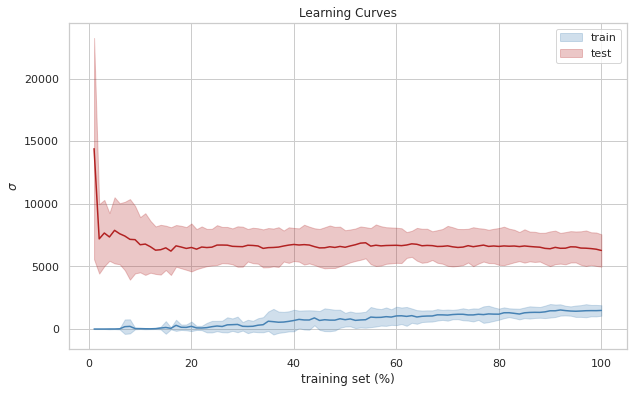

In [12]:
plot_learning_curves(lcurves, "$\sigma$")

It seems like we're over fitting the models to our data and we have a large gap between the train and test sets. However, it definitely seems like the sets have converged and getting more data will not improve the model. Decision trees are notoriously easy to overfit to our data so that is a consideration moving forward.

### Cross Validation

We've already computed the cross validation. Lets take a look at the results.

In [13]:
print(r"95% CI for $\sigma$:", stats.mstats.mquantiles(cval['test'], [0.025, 0.975]))

95% CI for $\sigma$: [ 530.86761679 3812.01052814]


The cross validation resulted in a bit of a range of $\sigma$, from 189 to 3994. It does lie in the range of what we predicted using the validation curves.

### Visualization

Visualization of the decision tree did not seem to be possible as it was too large to read.

### Model Comparison

Let's build a linear model from the Cars_MPG_Linear Modeling notebook and compare those results to our decision tree based model.

In [14]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=ins)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1976.96,740.33,3235.32
age_sq,$\beta_{1}$,3.34,3.17,3.53
male,$\beta_{2}$,-423.27,-1028.75,157.40
bmi,$\beta_{3}$,3.32,-38.32,42.57
smoke_yes,$\beta_{4}$,1590.26,-1359.99,5537.56
smoke_yes:bmi,$\beta_{5}$,466.06,325.10,571.37
smoke_yes:bmi_above_30,$\beta_{6}$,15211.86,14061.39,16489.83
children,$\beta_{7}$,695.83,455.43,994.97
male:children,$\beta_{8}$,-85.88,-532.28,247.78


Now we can perform cross-validation on the linear regression.

In [15]:

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics


In [16]:
lin_reg = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
lr_result = cross_validation(models.linear_regression, lin_reg, ins, lambda r: (r["sigma"], r["r_squared"]))

Let's use bootstrapping to estimate the ranges of our parameters.

In [17]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [18]:
tree_bootstrap = bootstrap_sample(cval['test'], np.mean)
lr_bootstrap = bootstrap_sample([r[0] for r in lr_result], np.mean)
difference = tree_bootstrap - lr_bootstrap

With the differences between the means of the two models calculated, we can now compare them:

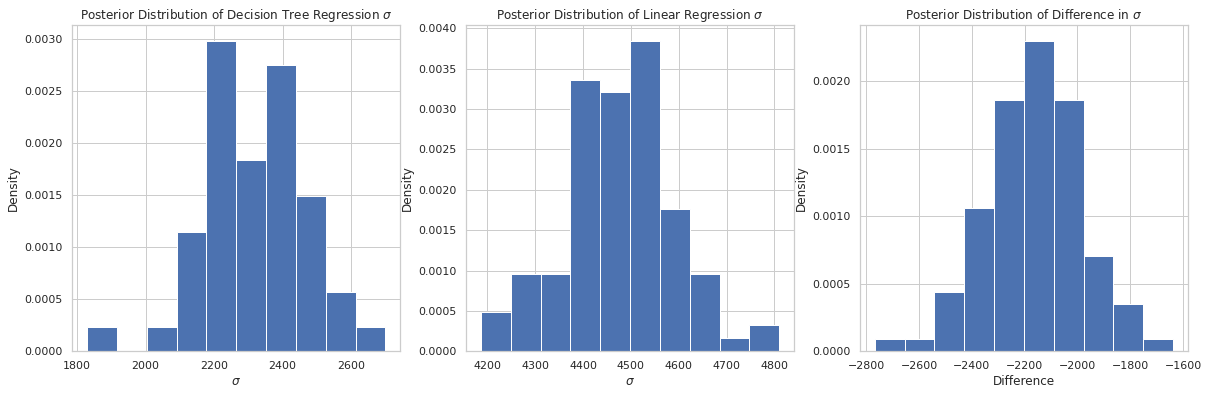

In [19]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(tree_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\sigma$")
axes.set_title( "Posterior Distribution of Decision Tree Regression $\sigma$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\sigma$")
axes.set_title( "Posterior Distribution of Linear Regression $\sigma$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $\sigma$")

plt.show()
plt.close()

Using a decision tree model to predict insurance charges, we have an average improvement (or reduction in error) of 2200 in our metric.

## Random Forest Comparison

Now will build a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model using the insurance data set, and use validation curves to optimize the hyperparameters. We will then estimate the generalization error using 3 rounds of 10 fold cross validation.

### Validation Curves

There are two parameters that we can consider as hyperparameters that sklearn uses for its random forest regressor: the number of decision trees in the forest and the number of features considered by each tree when splitting a node. We'll start by keeping the number of features considered by each tree the default which is all our features, and vary the number of decision trees in the forest. We'll modify the cross_validation function to be compatible with the forest regressor.

In [20]:
#cross validation of tree regression
def forest_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            
            # y, X for training data
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            model = builder.fit(X, y.ravel())
            y_hat = model.predict(X)
            
            #metrics["train"].append(model.score(X, y))
            metrics["train"].append(mse(y, model.predict(X), squared = False))
            
            # y, X for test data
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            #metrics["test"].append(model.score(X,y))
            metrics["test"].append(mse(y, model.predict(X), squared = False))

    
    return metrics

In [21]:
from sklearn.ensemble import RandomForestRegressor as forest
formula = "charges ~ 0 + bmi + age + male + smoke_yes + children"

values = range(1,40)

test_curve = []
train_curve = []
for x in values:
    builder = forest(x)
    results = forest_cross_validation(formula, builder, ins)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

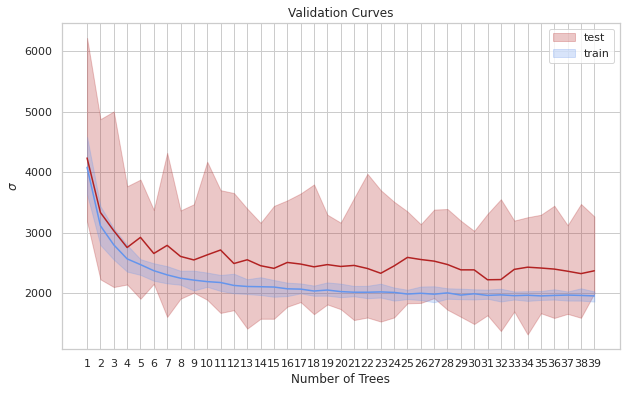

In [22]:
validation_curve(test_curve, train_curve, values, "$\sigma$", "Number of Trees")

Based on this validation curve, a good estimate for the number of trees to use in our random forest is 13, as this minimizes the test set RMSE and its difference to the RMSE of the train set. The test set doesn't improve much while the train set continues to reduce in error.

Using n = 13 as our number of trees we could attempt to modify the number of features per split. However because we only have 5 features in our model this doesn't really make too much sense. In addition, the validation curves provide a good sense of the error we might expect, so we can be confident in moving forward using the default number of features for each split.

### Cross Validation

Lets estimate our generalization error using a forest regressor that uses n = 13 as the number of trees.

In [23]:
builder = forest(13)
result = forest_cross_validation(formula, builder, ins)
print(r"95% CI for $\sigma$:", stats.mstats.mquantiles(result['test'], [0.025, 0.975]))

95% CI for $\sigma$: [1849.86505141 3435.68964687]


The cross validation indicates a range for sigma between 1786.8 to 3387. This is actually a tighter range then what a single decision tree regressor gave us.

### Feature Evaluation

The next thing we want to look at is how our features affect our model. Lets look at cross validation using different selections of features. We have 5 features to choose from barring any transformations.

In [24]:
from math import comb

comb(5,5) + comb(5, 4) + comb(5, 3) + comb(5, 2) + comb(5, 1)

31

In [25]:
formula

'charges ~ 0 + bmi + age + male + smoke_yes + children'

Using just those 5 features we have 31 ways to use our features ranging from just a single feature to all 5 features being incorporated into the model.

In [26]:
from itertools import combinations

features = ["age", "bmi", "male", "smoke_yes", "children"]
formulas = []
for x in range(1,5):
    comb = list(combinations(features, x))
    for y in comb:
        form = " + ".join(y)
        form = "charges ~ 0 + " + form
        formulas.append(form)
        
formulas.append(formula)
formulas

['charges ~ 0 + age',
 'charges ~ 0 + bmi',
 'charges ~ 0 + male',
 'charges ~ 0 + smoke_yes',
 'charges ~ 0 + children',
 'charges ~ 0 + age + bmi',
 'charges ~ 0 + age + male',
 'charges ~ 0 + age + smoke_yes',
 'charges ~ 0 + age + children',
 'charges ~ 0 + bmi + male',
 'charges ~ 0 + bmi + smoke_yes',
 'charges ~ 0 + bmi + children',
 'charges ~ 0 + male + smoke_yes',
 'charges ~ 0 + male + children',
 'charges ~ 0 + smoke_yes + children',
 'charges ~ 0 + age + bmi + male',
 'charges ~ 0 + age + bmi + smoke_yes',
 'charges ~ 0 + age + bmi + children',
 'charges ~ 0 + age + male + smoke_yes',
 'charges ~ 0 + age + male + children',
 'charges ~ 0 + age + smoke_yes + children',
 'charges ~ 0 + bmi + male + smoke_yes',
 'charges ~ 0 + bmi + male + children',
 'charges ~ 0 + bmi + smoke_yes + children',
 'charges ~ 0 + male + smoke_yes + children',
 'charges ~ 0 + age + bmi + male + smoke_yes',
 'charges ~ 0 + age + bmi + male + children',
 'charges ~ 0 + age + bmi + smoke_yes + child

Here we've generated 31 formulas that we can use to run a pseudo validation curve. Lets see what it looks like:

In [27]:
test_curve = []
train_curve = []
for formula in formulas:
    builder = forest(13)
    results = forest_cross_validation(formula, builder, ins)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

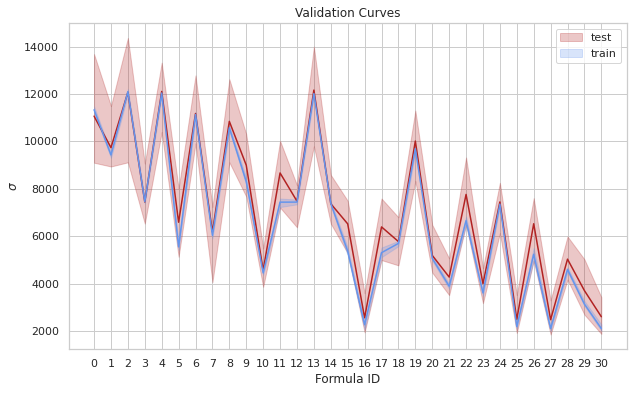

In [28]:
validation_curve(test_curve, train_curve, range(0,31), "$\sigma$", "Formula ID")

This chart is a little difficult to interpret but what we can do is use the indices to identify some of the better formula's used in our model. Based on the sigmas, we have formula 16, 25, 27 and 30 which all seem to minimize error.

In [29]:
goodModels = [16,25,27,30]
models = [formulas[i] for i in goodModels]
models

['charges ~ 0 + age + bmi + smoke_yes',
 'charges ~ 0 + age + bmi + male + smoke_yes',
 'charges ~ 0 + age + bmi + smoke_yes + children',
 'charges ~ 0 + bmi + age + male + smoke_yes + children']

Any combination of features that include age, bmi and smoking tend to perform the best, while removing either male, children, or both still results in a strong model. We can calculate importances to get a more quantitative measure of how homogenous the splits are based on the features we use.

In [30]:
builder = forest(13)
y, X = patsy.dmatrices(formula, ins, return_type="matrix")
model = builder.fit(X, y.ravel())
f_importances = model.feature_importances_

With the importances calculated we can chart them out:

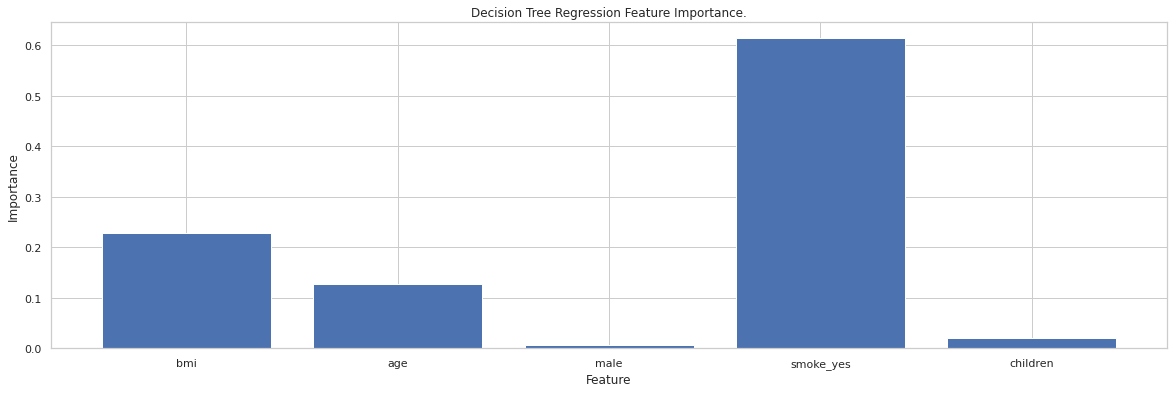

In [31]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)
xs = ["bmi", "age", "male" , "smoke_yes", "children"]

axes.bar(xs, f_importances)
axes.set_ylabel( "Importance")
axes.set_xlabel( "Feature")
axes.set_title( "Decision Tree Regression Feature Importance.")

plt.show()
plt.close()

As expected, both male and children have very little importance in the model. Smoking, age and BMI are all the variables that were significant in the regression.

### Model Comparison

Lets compare the random forest model using all 5 features to our linear regression. We already have the bootstrapped results from our linear regression, so lets generate the random forest bootstrap and calculate the differences.

In [32]:
forest_bootstrap = bootstrap_sample(result["test"], np.mean)
difference = forest_bootstrap - lr_bootstrap

Now we can plot our distributions to visualize them.

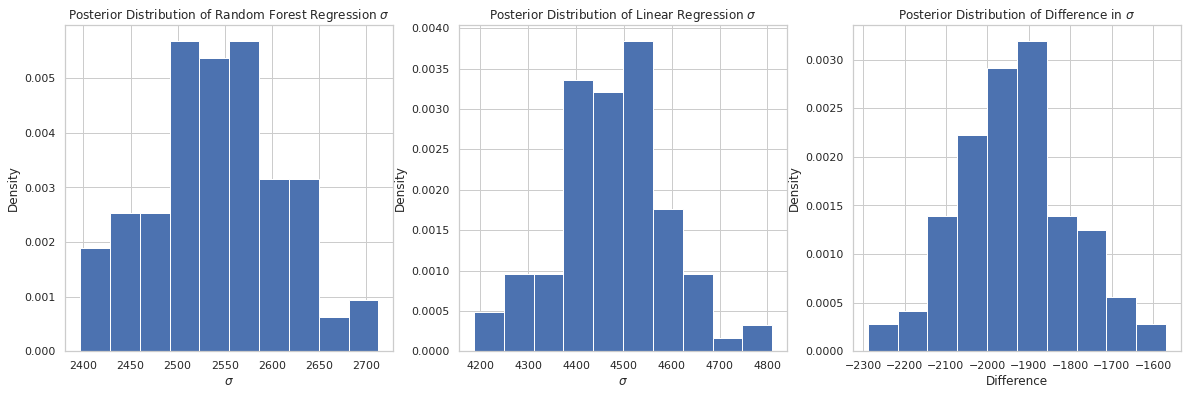

In [33]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(forest_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\sigma$")
axes.set_title( "Posterior Distribution of Random Forest Regression $\sigma$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\sigma$")
axes.set_title( "Posterior Distribution of Linear Regression $\sigma$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $\sigma$")

plt.show()
plt.close()

Based on the differences between the sigmas from the linear regression and the random forest regression, there is evidence that suggests that the random forest model outperforms the linear regression model.

In [34]:
print("The probability that our random forest model generates a smaller sigma then linear regression is", np.mean(difference < 0))

The probability that our random forest model generates a smaller sigma then linear regression is 1.0
